# 1D Inversion for Multiple Soundings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simpeg import (
    data,
)
import pickle
from forward_freq_survey import Forward_Freq_Survey
from layered_inversion import LayeredInversion

### Load Data and Plot

In [2]:
# path to the directory containing our data
dir_path = "../forward_data/" # or something else
filename = "forward_simulation_data_test0.pkl" # or something else

# files to work with
data_filename = dir_path + filename

In [3]:
with open(data_filename, "rb") as file:  # Open the file in read-binary mode
    loaded_data, loaded_earth = pickle.load(file)
print(len(loaded_data))

100


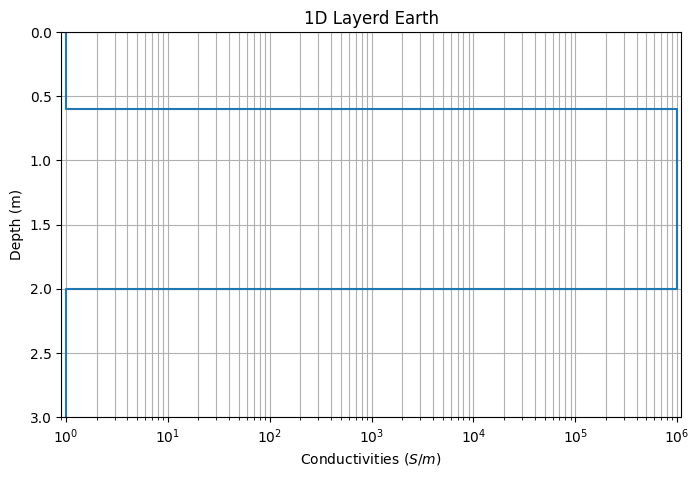

In [5]:
loaded_earth.plot_layered_earth((0,0))

In [74]:
z0 = 0.1
moment = 1
coil_spacing = 1
soil_conductivity = 1 # estimated soil conductivity
# Load in data
frequencies  = loaded_data[0]['frequencies']

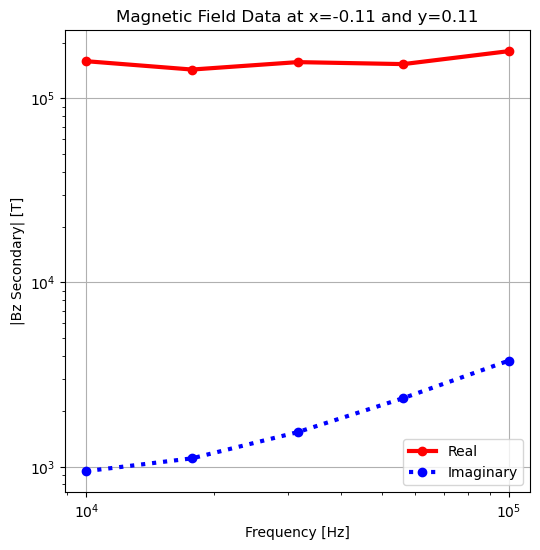

In [92]:
indx = 45
x = loaded_data[indx]["x"]
y = loaded_data[indx]["y"]
# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(frequencies, abs(loaded_data[indx]["hz_real"]), "r-o", lw=3)
ax.loglog(frequencies, abs(loaded_data[indx]["hz_imag"]), "b:o", lw=3)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title(f"Magnetic Field Data at x={round(x,2)} and y={round(y,2)}")
ax.legend(["Real", "Imaginary"])
plt.grid()
plt.show()

## Perform Inversions on Soundings at All Positions

In [93]:
def create_data_object(loaded_data, survey, error=0.05):
    hz_real = loaded_data['hz_real']
    hz_imag = loaded_data['hz_imag']
    dobs = np.empty(len(hz_real)+len(hz_imag))
    dobs[0::2] = hz_real
    dobs[1::2] = hz_imag
    uncertainties = error * np.abs(dobs) * np.ones_like(dobs)
    data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)
    return data_object

In [94]:
# define simulation
sim = Forward_Freq_Survey(frequencies, z0, moment, coil_spacing)

In [95]:
survey = sim.survey
data_object = create_data_object(loaded_data[indx], survey)
# Initialize LayeredInversion with current data_object and simulation parameters
layered_inversion = LayeredInversion(
        data_object=data_object, 
        survey=survey, 
        soil_conductivity=soil_conductivity,
        beta0_ratio=1e0,
        coolingFactor=1.0, 
        coolingRate=1.0,
)
# Run the inversion and store the recovered model
recovered_L2model = layered_inversion.run_inversion()



Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.84e+03  9.25e+05  0.00e+00  9.25e+05    5.15e+05      0              
   1  2.84e+03  1.61e+05  8.30e+00  1.85e+05    7.90e+04      0              
   2  2.84e+03  3.24e+04  1.40e+01  7.23e+04    1.19e+04      0   Skip BFGS  
   3  2.84e+03  1.90e+04  1.71e+01  6.76e+04    3.96e+03      0   Skip BFGS  
   4  2.84e+03  2.24e+04  1.58e+01  6.75e+04    3.61e+03      0              
   5  2.84e+03  2.05e+04  1.65e+01  6.74e+04    2.75e+03      0         

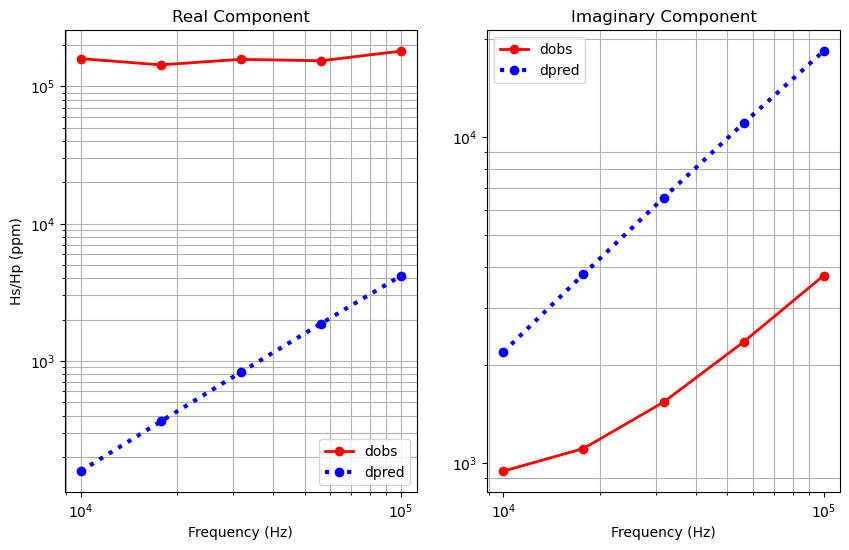

In [96]:
dpred =  layered_inversion.simulation.dpred(recovered_L2model)
# Plot FEM response for all frequencies at specified index
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6))
ax1.loglog(frequencies, abs(loaded_data[indx]["hz_real"]), "r-o", lw=2, label="dobs")
ax1.loglog(frequencies, dpred[0::2], "b:o", lw=3, label="dpred")
ax2.loglog(frequencies, abs(loaded_data[indx]["hz_imag"]), "r-o", lw=2, label="dobs")
ax2.loglog(frequencies, dpred[1::2], "b:o", lw=3, label="dpred")
ax1.set_ylabel("Hs/Hp (ppm)")
ax1.set_title("Real Component")
ax2.set_title("Imaginary Component")

for ax in [ax1, ax2]:
    ax.set_xlabel("Frequency (Hz)")
    ax.grid(which="both")
    ax.legend()

plt.grid()
plt.show()

## Plot in 3D by Projecting 1D Data onto 3D mesh

## Interpolation between Each Recovered Models